In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from cycler import cycler
sys.path.append("../../")
from TCN.soil_classification.model import SimpleVAE
from TCN.soil_classification.utils import data_generator, data_generator_test
from TCN.soil_classification.model_AE import TCNAE, ConvAE, DenseTCNAE, ConvTCNAE, DenseLastTCNAE, DenseAE
from TCN.soil_classification.model_VAE import  DenseVAE, ConvVAE

from sklearn.manifold import TSNE

In [52]:
# Definitions for data indicies
LIN_ACC_X = 1
LIN_ACC_Y = 2
LIN_ACC_Z = 3
ANG_VEL_X = 4
ANG_VEL_Y = 5
ANG_VEL_Z = 6
ORIENT_X = 7
ORIENT_Y = 8
ORIENT_Z = 9
ORIENT_W = 10
POS_X = 11
POS_Z = 12
ANG = 13
BOOM = 14
DIPPER = 15
TELE = 16
PITCH = 17
labels = ["Lin. acc. x","Lin. acc. y","Lin. acc. z","Ang. vel. x","Ang. vel. y","Ang. vel. z", "ori_x", "ori_y",
          "ori_z", "ori_w", "pos_x", "pos_z", "ang", "Boom", "Dipper", "Tele", "Pitch"]

In [68]:
PATH ="AE_model/bs256_do25_seq100_imu_no_orient+torques_phase2/bs256_do25_seq100_imu_no_orient+torques_phase2_ep2.pt"
PATH ="AE_model/bs256_do0_seq100_imu_no_orient+torques_phase2/bs256_do0_seq100_imu_no_orient+torques_phase2_ep19.pt"
PATH ="AE_model/Rev_bs256_do0_seq100_imu_no_orient+torques_phase2/Rev_bs256_do0_seq100_imu_no_orient+torques_phase2_ep12.pt"
PATH ="AE_model/Dense_bs256_do20_seq100_imu_no_orient+torques_phase2_nlf10/Dense_bs256_do20_seq100_imu_no_orient+torques_phase2_nlf10_ep20.pt"
#PATH ="AE_model/Conv_bs256_do20_seq100_imu_no_orient+torques_phase2_nlf10/Conv_bs256_do20_seq100_imu_no_orient+torques_phase2_nlf10_ep1.pt"
PATH = "AE_model/DenseAE_bs256_do0_seq100_imu_no_orient+torques_phase2_nlf5/DenseAE_bs256_do0_seq100_imu_no_orient+torques_phase2_nlf5_ep64.pt"
PATH = "AE_model/ConvAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf5/ConvAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf5_ep64.pt"
PATH = "AE_model/DenseVAE_bs256_do0_seq100_imu_no_orient+torques_phase2_nlf50/DenseVAE_bs256_do0_seq100_imu_no_orient+torques_phase2_nlf50_ep64.pt"
PATH = "AE_model/DenseVAE_bs256_do0_seq100_imu_no_orient+torques_phase2_nlf50/DenseVAE_bs256_do0_seq100_imu_no_orient+torques_phase2_nlf50_ep64.pt"
PATH = "AE_model/ConvAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf240/ConvAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf240_ep64.pt"
PATH = "AE_model/ConvAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/ConvAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep64.pt"

train_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/train"
test_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/test"

variable_set = [list(range(LIN_ACC_X,ANG_VEL_Z+1,1))+list(range(BOOM,PITCH+1,1))]
seq_len = 128
phase = 2

X_train, Y_train = data_generator(train_folder, seq_len, seq_len-1, phase =phase, val_mask=variable_set[0])
X_test, Y_test, plotting, files = data_generator_test(test_folder, seq_len, seq_len-1, phase =phase, val_mask=variable_set[0])

#mins, _ = torch.min(torch.min(X_train,1)[0],0)
#maxs, _ = torch.max(torch.max(X_train,1)[0],0)

m = X_train.mean(0, keepdim=True)
s = X_train.std(0, unbiased=False, keepdim=True)
X_train -= m
X_train /= s

#X_train = (X_train-mins)/(maxs-mins)
X_train = X_train.permute(0,2,1)

for traj_idx in range(len(X_test)):
    #X_test[traj_idx] = (X_test[traj_idx]-mins)/(maxs-mins)
    X_test[traj_idx] -= m
    X_test[traj_idx] /= s
    X_test[traj_idx] = X_test[traj_idx].permute(0,2,1)

channel_sizes = [30,30,30,30,30,4]#[30]*4 #[30,20,10,1]#
kernel_size = 7
input_channels = X_train.shape[1]
latent_dim = 50

hidden_dims = [1000,800,500, 200,160, 80]
hidden_dims = [1000, 500, 200, 80]

#model = TCNAE(input_channels, 10, 10, channel_sizes, kernel_size=kernel_size, dropout=0.25)
#model = TCNAERevDialation(input_channels, 10, 10, channel_sizes, kernel_size=kernel_size, dropout=0.25)
#model = DenseTCNAE(input_channels, latent_dim, seq_len, channel_sizes, kernel_size=kernel_size, dropout = 0.25)
#model = ConvTCNAE(input_channels, 10, channel_sizes, kernel_size=kernel_size, dropout = 0.25)
#model = DenseLastTCNAE(input_channels, latent_dim, seq_len, channel_sizes, kernel_size=kernel_size, dropout = 0.25)
#model = DenseAE(input_channels, seq_len, latent_dim, hidden_dims)
model = ConvAE(input_channels, channel_sizes, kernel_size)
#model = DenseVAE(input_channels, seq_len, latent_dim, hidden_dims)

model.load_state_dict(torch.load(PATH))
model.eval()

ConvAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv1d(10, 30, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(30, 30, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(30, 30, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(30, 30, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
    (4): Sequential(
      (0): Conv1d(30, 30, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
    (5): Sequential(
      (0): Conv1d(30, 4, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose1d(4, 30, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose1d(30, 30, kernel_size=(7,), stride=(2,), padding=(3,

In [69]:
X_train.shape

torch.Size([11628, 10, 128])

In [70]:
with torch.no_grad():
    model.eval()
    output = []
    for x in X_test:
        output.append(model(x))

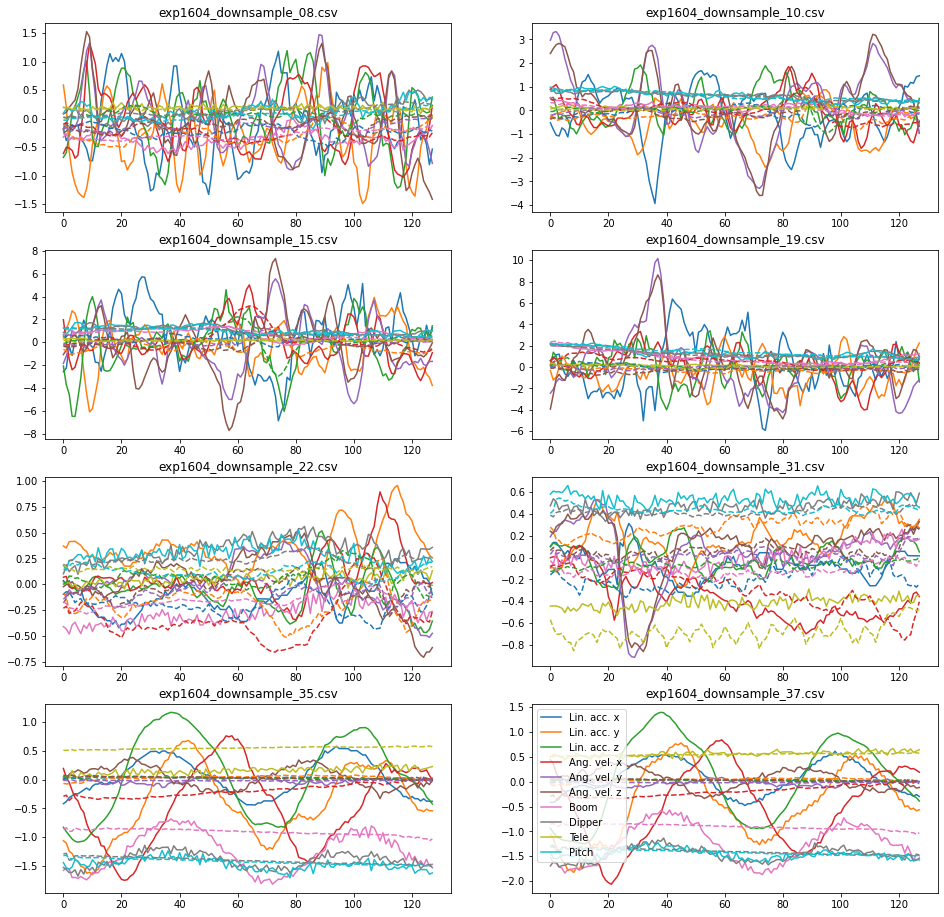

In [71]:
idx = 120
legend = [labels[i-1] for i in variable_set[0]]
rows = int((len(plotting)+1)/2) 
fig, ax1 = plt.subplots(rows,2,figsize = [16,4*rows])
plt.gca().set_prop_cycle(None)
for a1,d,f,out in zip(ax1.reshape(-1),plotting,files,output):
    a1.title.set_text(f)
    a1.plot(out[1][idx].T)   
    plt.gca().set_prop_cycle(None)
    a1.plot(out[0][idx].T,linestyle="--")
plt.legend(legend)
plt.show()

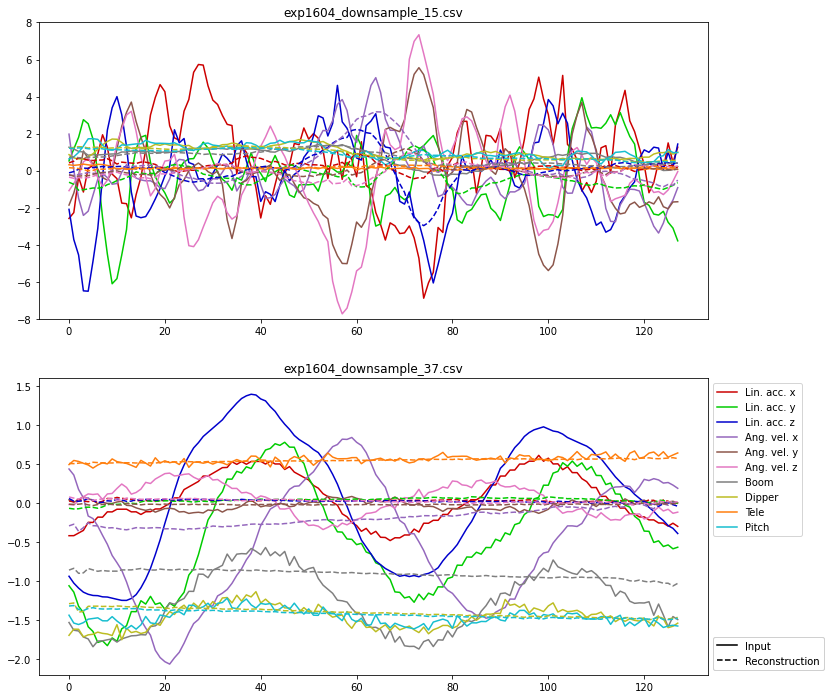

In [72]:
import matplotlib.lines as mlines
idx = 120
legend = [labels[i-1] for i in variable_set[0]]
rows = 2
fig, ax1 = plt.subplots(rows,1,figsize = [12,6*rows])

custom_cycler = cycler(color=[[0.8,0,0], [0,0.8,0], [0,0,0.8], '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#ff7f0e','#17becf'])

fl = [files[2],files[-1]]
pl = [plotting[2],plotting[-1]]
oo = [output[2],output[-1]]

for a1,d,f,out in zip(ax1.reshape(-1),pl,fl,oo):
    a1.title.set_text(f)
    a1.set_prop_cycle(custom_cycler)
    a1.plot(out[1][idx].T)   
    a1.set_prop_cycle(custom_cycler)
    a1.plot(out[0][idx].T,linestyle="--")
legend1 = plt.legend(legend,bbox_to_anchor=(1., 1.0), loc='upper left')
inputs = mlines.Line2D([], [], color='black', ls='-', label='Input')
recs = mlines.Line2D([], [], color='black', ls='--', label='Reconstruction')
legend2 = plt.legend(handles=[inputs,recs],bbox_to_anchor=(1., 0), loc='lower left')
ax1[0].set_ylim([-8,8])
ax1[1].set_ylim([-2.2,1.6])
plt.gca().add_artist(legend2)
plt.gca().add_artist(legend1)
plt.show()

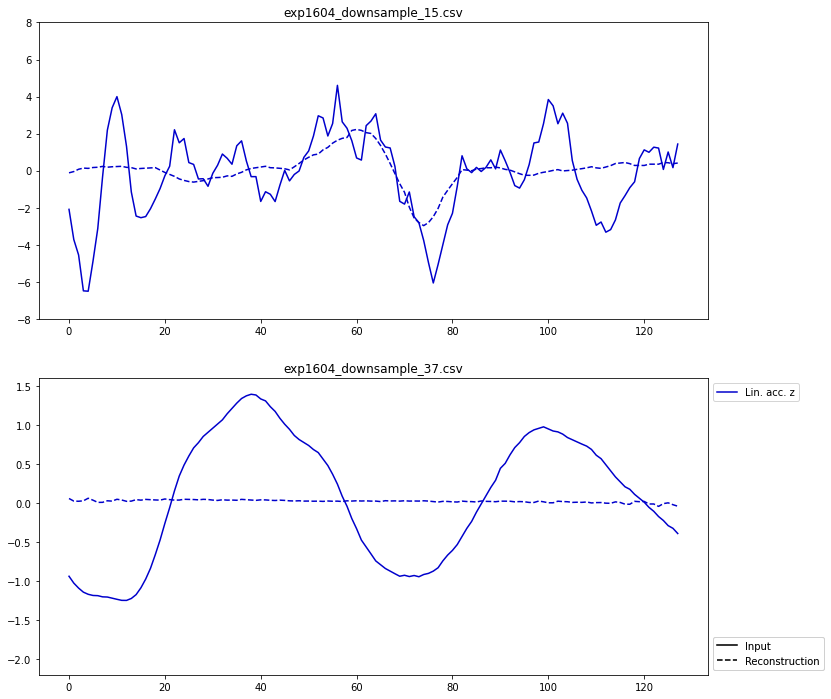

In [73]:
idx = 120
legend = [labels[i-1] for i in variable_set[0]]
rows = 2
fig, ax1 = plt.subplots(rows,1,figsize = [12,6*rows])

custom_cycler = cycler(color=[[0.8,0,0], [0,0.8,0], [0,0,0.8], '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#ff7f0e','#17becf'])

fl = [files[2],files[-1]]
pl = [plotting[2],plotting[-1]]
oo = [output[2],output[-1]]

for a1,d,f,out in zip(ax1.reshape(-1),pl,fl,oo):
    a1.title.set_text(f)
    a1.set_prop_cycle(custom_cycler)
    a1.plot(out[1][idx,2].T, color = [0,0,0.8])   
    a1.set_prop_cycle(custom_cycler)
    a1.plot(out[0][idx,2].T,color = [0,0,0.8],linestyle="--")
legend1 = plt.legend(["Lin. acc. z"],bbox_to_anchor=(1., 1.0), loc='upper left')
inputs = mlines.Line2D([], [], color='black', ls='-', label='Input')
recs = mlines.Line2D([], [], color='black', ls='--', label='Reconstruction')
legend2 = plt.legend(handles=[inputs,recs],bbox_to_anchor=(1., 0), loc='lower left')
plt.gca().add_artist(legend2)
plt.gca().add_artist(legend1)
ax1[0].set_ylim([-8,8])
ax1[1].set_ylim([-2.2,1.6])
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [155]:
print(mins,"\n", maxs)

tensor([-2.6700e+00, -8.6000e+00, -1.6380e+01, -8.2767e-02, -2.5853e-01,
        -1.4454e-01, -1.5429e+05, -4.1934e+04, -9.7548e+04, -9.8025e+03]) 
 tensor([ 2.1400e+00, -4.1000e-01, -7.2000e-01,  2.5689e-01,  2.4135e-01,
         1.6376e-01,  4.5300e+04,  7.3492e+04,  2.8611e+03,  3.9476e+04])


In [156]:
X_tr, Y_tr = data_generator(train_folder, seq_len, seq_len-1, phase =phase, val_mask=variable_set[0])
m = X_tr.mean(0, keepdim=True)
s = X_tr.std(0, unbiased=False, keepdim=True)
X_tr -= m
X_tr /= s

## Plot t-SNE

In [22]:
x_te = torch.cat(X_test)
y_te = torch.cat(Y_test)

In [23]:
with torch.no_grad():
    model.eval()
    encoded = model.encode(X_train)
    encoded = model.reparameterize(*encoded)

In [24]:
colors = ["r", "g", "b", "c"]
projected = TSNE(n_components=2).fit_transform(torch.flatten(encoded, start_dim=1))

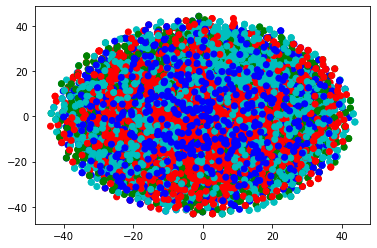

In [26]:
plt.figure()
plt.scatter(projected[:,0],projected[:,1], c= [colors[i] for i in Y_train])
plt.show()

In [17]:
print(encoded[800])

tensor([-0.0353,  2.2233, -1.0835,  0.6453,  0.7697])


In [14]:
with torch.no_grad():
    out = model(X_train[8000:12000])

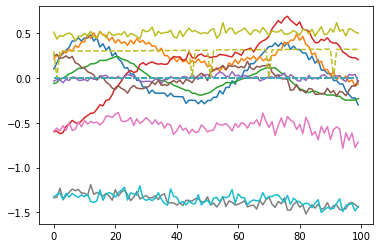

In [15]:
plt.figure()
plt.plot(out[1][400].T)
plt.gca().set_prop_cycle(None)
plt.plot(out[0][400].T, linestyle="--")
plt.show()

In [65]:
X_train.shape

torch.Size([12636, 10, 100])